# Péndulo intervertido

Parámetros:

(M)       mass of the cart                         0.5 kg

(m)       mass of the pendulum                     0.2 kg

(b)       coefficient of friction for cart         0.1 N/m/sec

(l)       length to pendulum center of mass        0.3 m

(I)       mass moment of inertia of the pendulum   0.006 kg.m^2

(F)       force applied to the cart

(x)       cart position coordinate

(theta)   pendulum angle from vertical (down)

## Esquema

![Péndulo invertido](pendulum2.png)

## Ecuaciones lineales

$$
\left[{\begin{array}{c}
  \dot{x}\\ \ddot{x}\\ \dot{\phi}\\ \ddot{\phi}
\end{array}}\right] =
\left[{\begin{array}{cccc}
  0&1&0&0\\
  0&\frac{-(I+ml^2)b}{I(M+m)+Mml^2}&\frac{m^2gl^2}{I(M+m)+Mml^2}&0\\
  0&0&0&1\\
  0&\frac{-mlb}{I(M+m)+Mml^2}&\frac{mgl(M+m)}{I(M+m)+Mml^2}&0
\end{array}}\right]
\left[{\begin{array}{c}
  x\\ \dot{x}\\ \phi\\ \dot{\phi}
\end{array}}\right]+
\left[{\begin{array}{c}0\\
  \frac{I+ml^2}{I(M+m)+Mml^2}\\
  0 \\
  \frac{ml}{I(M+m)+Mml^2}
\end{array}}\right]u$$

$${\bf y} =
\left[{\begin{array}{cccc}
  1&0&0&0\\0&0&1&0
\end{array}}\right]
\left[{\begin{array}{c}
  x\\ \dot{x}\\ \phi\\ \dot{\phi}
\end{array}}\right]+
\left[{\begin{array}{c}
  0\\0
\end{array}}\right]u$$

In [1]:
import matplotlib.animation as animation
import numpy as np
import matplotlib.pyplot as plt
import control as ctrl
import random

In [2]:
M = 0.5
m = 0.2
b = 0.1
I = 0.006
g = 9.8
l = 0.3
p = I*(M+m)+M*m*l**2;

In [3]:
A = np.matrix([[0, 1, 0,0],
     [0, -(I+m*l**2)*b/p,  (m**2*g*l**2)/p, 0],
     [0, 0, 0,  1],
     [0, -(m*l*b)/p, m*g*l*(M+m)/p, 0]])

B =np.matrix([[0],
     [(I+m*l**2)/p],
          [0],
        [m*l/p]])

C = np.matrix([[1, 0, 0, 0],
     [0, 0, 1, 0]])

D = np.matrix([[0],
               [0]])

states = ['x', 'x_dot', 'phi', 'phi_dot']
inputs = ['u']
outputs = ['x', 'phi']

pendulo = ctrl.ss(A,B,C,D, states=states, inputs=inputs, outputs=outputs)
pendulo

<LinearIOSystem:sys[2]:['u']->['x', 'phi']>

(array([ 0.        +0.j, -0.14283164+0.j, -5.60409413+0.j,  5.56510758+0.j]),
 array([], dtype=float64))

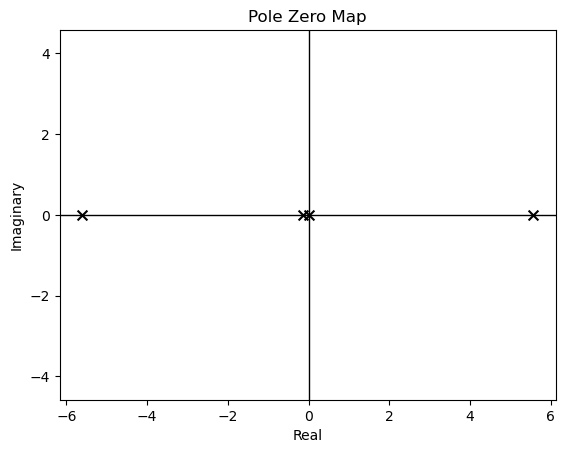

In [4]:
ctrl.pzmap(pendulo)

## Diseño de la ley de control
elegi lo poslos en forma arbitraria

In [5]:
p1 = -10 + 10j;
p2 = -10 - 10j;
p3 = -50;
p4 = -40;
p_obj1= [p1, p2, p3,p4]

K1 = ctrl.place(A,B,p_obj1);
print(K1)
sys_cl1 = ctrl.ss(A-B*K1,B,C,0,);

sys_cl1.pole()

[[-8979.59183674 -1302.14081633  4478.6967347    545.01632653]]


array([-50. +0.j, -40. +0.j, -10.+10.j, -10.-10.j])

Text(0, 0.5, 'Angular Posición (rad)/ Posición (m)')

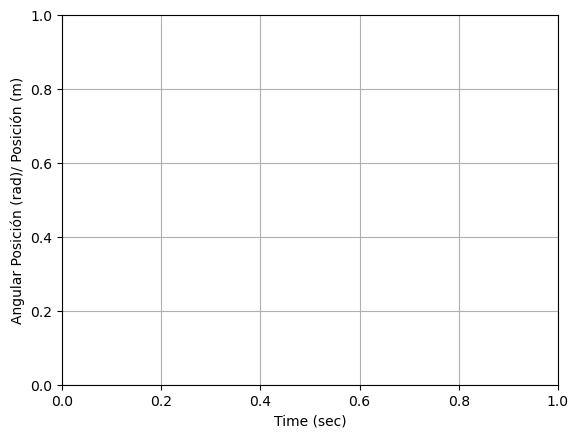

In [6]:
n = 300
tf = 2
time = np.linspace(0,tf,n)

u = np.zeros(time.size)
x0 = [0, 0, np.radians(1), 0]

t1,y1,x1 =ctrl.forced_response(sys_cl1,U=u,T=time,X0=x0,return_x=True)
x=y1[0,:];
theta_a=y1[1,:];

#plt.plot(t1,x)#pos
#plt.plot(t1,theta_a)#angulo en rad

plt.grid()
plt.xlabel('Time (sec)')
plt.ylabel('Angular Posición (rad)/ Posición (m)')

## Estimador total

In [7]:
m_obsv = ctrl.obsv(A,C)
print('\n')
rango_obsv = np.linalg.matrix_rank(m_obsv)
print(m_obsv)
print("Rango la matriz de observabilidad:",rango_obsv)



[[ 1.          0.          0.          0.        ]
 [ 0.          0.          1.          0.        ]
 [ 0.          1.          0.          0.        ]
 [ 0.          0.          0.          1.        ]
 [ 0.         -0.18181818  2.67272727  0.        ]
 [ 0.         -0.45454545 31.18181818  0.        ]
 [ 0.          0.03305785 -0.48595041  2.67272727]
 [ 0.          0.08264463 -1.21487603 31.18181818]]
Rango la matriz de observabilidad: 4


In [8]:
#5 veces respecto a los polos p_obj2
pe_obj1=p_obj1*np.array(5)
pe_obj1

array([ -50.+50.j,  -50.-50.j, -250. +0.j, -200. +0.j])

In [9]:
L = ctrl.place(pendulo.A.T,pendulo.C.T,pe_obj1).T
L

array([[   246.75596768,    -44.649339  ],
       [  9198.90933458, -11756.04271451],
       [    54.74377611,    303.06221414],
       [ 10564.70562188,  13505.62220717]])

In [10]:
 np.linalg.eigvals(A-L@C)

array([ -50.+50.j,  -50.-50.j, -200. +0.j, -250. +0.j])

In [11]:
Ae=A-L@C-B@K1 #A*x_e-B*u-L(y-C*x_e)
Be=L#np.hstack([B,L]) 
Ce=-K1# u=-K*x_e
De=np.zeros([1,2])
Ae,Be,Ce,De

(matrix([[-2.46755968e+02,  1.00000000e+00,  4.46493390e+01,
           0.00000000e+00],
         [ 7.12762128e+03,  2.36734694e+03,  3.61563047e+03,
          -9.90938776e+02],
         [-5.47437761e+01,  0.00000000e+00, -3.03062214e+02,
           1.00000000e+00],
         [ 3.02516209e+04,  5.91836735e+03, -3.38321528e+04,
          -2.47734694e+03]]),
 array([[   246.75596768,    -44.649339  ],
        [  9198.90933458, -11756.04271451],
        [    54.74377611,    303.06221414],
        [ 10564.70562188,  13505.62220717]]),
 array([[ 8979.59183674,  1302.14081633, -4478.6967347 ,  -545.01632653]]),
 array([[0., 0.]]))

In [12]:
states = ['x_est', 'x_est_dot', 'phi_est', 'phi_est_dot']
inputs = ['x','phi']#la entrada y no puede ser de 2x1 tengo que separar
outputs = ['u']

#regulador con estimador total ley de control u=-k*x_est + estimador total
reg_est_tot = ctrl.ss(Ae,Be,Ce,De, states=states, inputs=inputs, outputs=outputs)
reg_est_tot

<LinearIOSystem:sys[4]:['x', 'phi']->['u']>

## modelo no lineal
$$(M+m)\ddot{x}+b\dot{x}+ml\ddot{\theta}\cos\theta-ml\dot{\theta}^2\sin\theta=F $$
$$(I+ml^2)\ddot{\theta}+mgl\sin\theta=-ml\ddot{x}\cos\theta $$

In [13]:
def pendulo_derivs(t, x, u, params):
    # Parámetros, tienen valores por defecto
    M=params.get('M', 0.5)#kg
    m=params.get('m', 0.2)#kg
    b=params.get('b', 0.1)
    #I=params.get('I', 0.006)
    g=params.get('g', 9.8)#m/s^2
    l=params.get('l', 0.3)#m
        
    # variables de estado
    pos       = x[0]#m
    vel       = x[1]#m/s
    theta     = x[2]#rad
    theta_dot = x[3]#rad/s
    
    # Cálculo de la acción de control
    F = u[0] #[N] if u[0] > 0 else 0 # solo caudales positivos
    
    #calculo de la derivada de x, x_dot, theta, theta_dot... dh/dt
    dpos       = vel #x1_dot
    dvel       = (F+m*l*theta_dot**2*np.sin(theta)-m*g*np.sin(theta)*np.cos(theta))/(M+m*np.sin(theta)**2)
    dtheta     = theta_dot
    dtheta_dot = (-F*np.cos(theta)+(M+m)*g*np.sin(theta)-m*l*theta_dot**2*np.cos(theta)*np.sin(theta))/((m*np.sin(theta)**2+M)*l)
    
    return np.array([dpos, dvel, theta_dot, dtheta_dot])

def pendulo_outputs(t, x, u, params):
    "Las ecuaciones de las salida"
    return [x[0],x[2]]#[x[0]+random.normalvariate(0,0.001),x[2]+random.normalvariate(0,0.001)]

io_pendulo = ctrl.NonlinearIOSystem(
    pendulo_derivs, pendulo_outputs, inputs=('u'), outputs=('x','phi'),
    states=('x','vel','phi','theta_dot'), name='pendulo_nolin')

In [14]:
ley_c=ctrl.ss(np.zeros([4,4]),np.zeros([4,4]),np.zeros([1,4]),-K1,outputs=['u'],inputs=['pos','vel','theta','theta_dot'])
ley_c

<LinearIOSystem:sys[5]:['pos', 'vel', 'theta', 'theta_dot']->['u']>

In [15]:
pendulum_nolin_lc=ctrl.interconnect([io_pendulo,reg_est_tot])

Text(0, 0.5, '$theta$ [grad]')

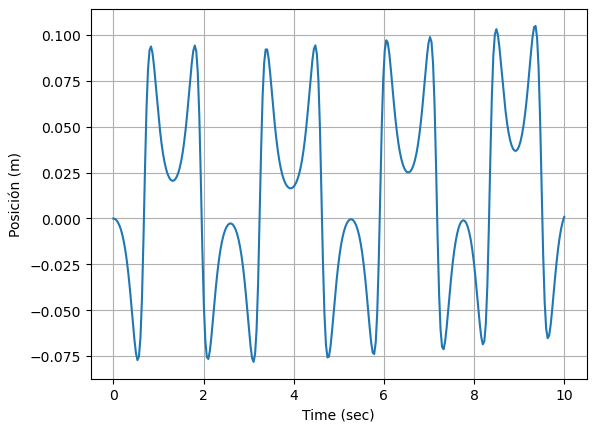

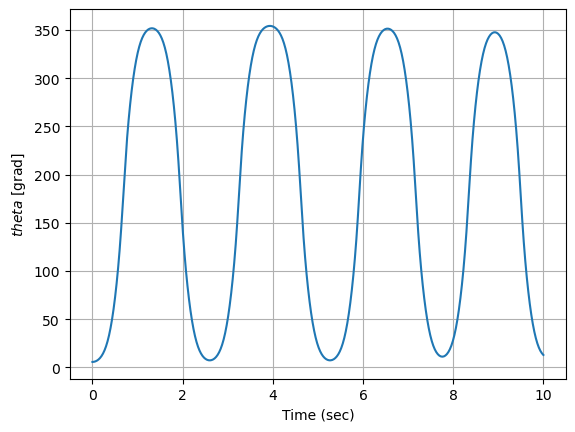

In [16]:
n = 300
tf = 10
time = np.linspace(0,tf,n)

u = np.zeros(time.size)
x0 = [0, 0, 0.1, 0]

t1,y1 = ctrl.input_output_response(io_pendulo, time, u[0], x0)
x=y1[0,:];
theta_a=y1[1,:];
plt.figure()
plt.plot(t1,x)#pos
plt.grid()
plt.xlabel('Time (sec)')
plt.ylabel('Posición (m)')
plt.figure()
plt.plot(t1,theta_a*180/np.pi)#angulo en rad
plt.grid()
plt.xlabel('Time (sec)')
plt.ylabel('$theta$ [grad]')

In [17]:
#Weight of item
m2 = np.ones(n)


x1 = x
y1 = np.zeros(len(time))

#suppose that l = 1
x2 = 1*np.sin(theta_a)+x1
x2b = 1.05*np.sin(theta_a)+x1
y2 = 1*np.cos(theta_a)-y1
y2b = 1.05*np.cos(theta_a)-y1

#plt.plot(time,x2)
#plt.grid()

In [32]:
%matplotlib qt5

# Pendulum animation by Everton Colling

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111,autoscale_on=False,\
                     xlim=(-2,2),ylim=(-2,2))
ax.set_xlabel('position')
ax.set_aspect('equal', adjustable='box')
ax.get_yaxis().set_visible(False)

crane_rail, = ax.plot([-2.0,2.0],[-0.2,-0.2],'k-',lw=4)

start, = ax.plot([-1,-1],[-2,2],'k:',lw=2)
pos2, = ax.plot([1,1],[-2,2],'k:',lw=2)
objective, = ax.plot([0,0],[-2,2],'k:',lw=2)

mass1, = ax.plot([],[],linestyle='None',marker='s',\
                 markersize=40,markeredgecolor='k',\
                 color='orange',markeredgewidth=2)
mass2, = ax.plot([],[],linestyle='None',marker='o',\
                 markersize=20,markeredgecolor='k',\
                 color='orange',markeredgewidth=2)
line, = ax.plot([],[],'o-',color='orange',lw=4,\
                markersize=6,markeredgecolor='k',\
                markerfacecolor='k')
time_template = 'time = %.1fs'
time_text = ax.text(0.05,0.9,'',transform=ax.transAxes)
wgt_template = 'weight = %.1f'
wgt_text = ax.text(0.75,0.9,'',transform=ax.transAxes)
#start_text = ax.text(-1.06,-0.3,'pos1',ha='right')
end_text = ax.text(0.06,-0.3,'objective',ha='left')

def init():
    mass1.set_data([],[])
    mass2.set_data([],[])
    line.set_data([],[])
    time_text.set_text('')
    wgt_text.set_text('')
    return line, mass1, mass2, time_text, wgt_text

def animate(i):
    mass1.set_data([x1[i]],[y1[i]-0.1])
    mass2.set_data([x2b[i]],[y2b[i]])
    line.set_data([x1[i],x2[i]],[y1[i],y2[i]])
    time_text.set_text(time_template % time[i])
    wgt_text.set_text(wgt_template % m2[i])
    return line, mass1, mass2, time_text, wgt_text

ani_a = animation.FuncAnimation(fig, animate, \
         np.arange(1,len(time)), \
         interval=40,blit=False,init_func=init)

# requires ffmpeg to save mp4 file
#  available from https://ffmpeg.zeranoe.com/builds/
#  add ffmpeg.exe to path such as C:\ffmpeg\bin\ in
#  environment variables
#ani_a.save('Pendulum_Control.mp4',fps=30)
#ani_a.save('animation.gif', writer='PillowWriter', fps=30)
plt.show()